In [4]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load both audio signals
# ---------------------------------------------------------
path1 = "/content/drive/MyDrive/lab test/hello-87032.mp3"   # your voice
path2 = "/content/drive/MyDrive/lab test/hello_me.m4a"      # friend's voice

signal1, sr1 = librosa.load(path1, sr=None)
signal2, sr2 = librosa.load(path2, sr=None)

print("Signal 1:", len(signal1), "samples | SR =", sr1)
print("Signal 2:", len(signal2), "samples | SR =", sr2)

/tmp/ipython-input-1072046055.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  signal2, sr2 = librosa.load(path2, sr=None)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Signal 1: 39168 samples | SR = 48000
Signal 2: 217088 samples | SR = 48000


In [5]:
# ---------------------------------------------------------
# 2. Normalize amplitudes
# ---------------------------------------------------------
signal1_norm = signal1 / np.max(np.abs(signal1))
signal2_norm = signal2 / np.max(np.abs(signal2))

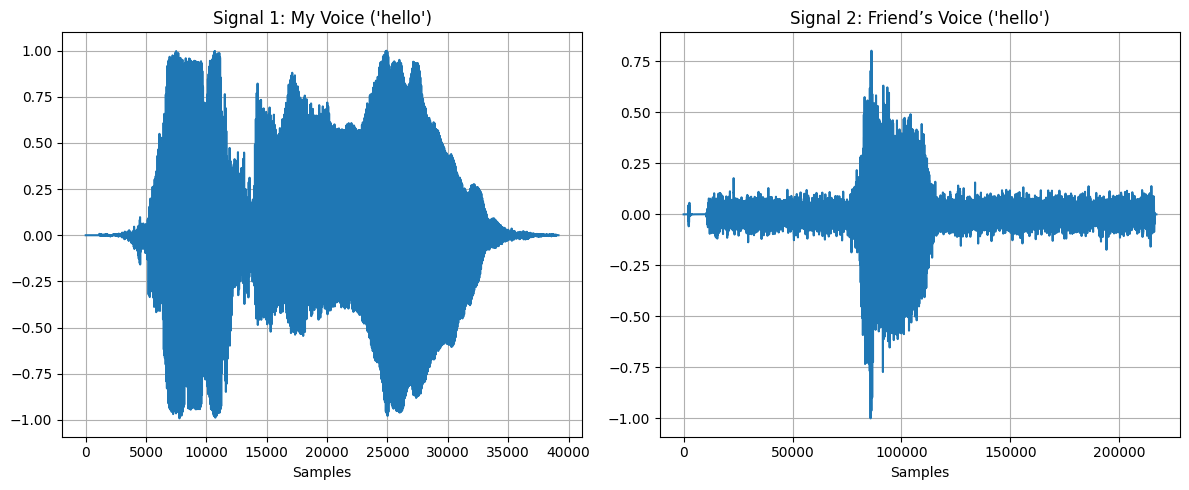

In [6]:
# ---------------------------------------------------------
# 3. Visualize both waveforms
# ---------------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(signal1_norm)
plt.title("Signal 1: My Voice ('hello')")
plt.xlabel("Samples")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(signal2_norm)
plt.title("Signal 2: Friend’s Voice ('hello')")
plt.xlabel("Samples")
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# ---------------------------------------------------------
# 4. Downsample (lighter computation)
# ---------------------------------------------------------
factor = 10  # safer than 50
signal1_small = signal1_norm[::factor]
signal2_small = signal2_norm[::factor]

print("Downsampled Signal 1 length:", len(signal1_small))
print("Downsampled Signal 2 length:", len(signal2_small))

Downsampled Signal 1 length: 3917
Downsampled Signal 2 length: 21709


In [8]:
# ---------------------------------------------------------
# 5. Implement DTW
# ---------------------------------------------------------
def dtw(x, y):
    n = len(x)
    m = len(y)

    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - y[j-1])
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],   # insertion
                dtw_matrix[i, j-1],   # deletion
                dtw_matrix[i-1, j-1]  # match
            )
    return dtw_matrix

dtw_matrix = dtw(signal1_small, signal2_small)

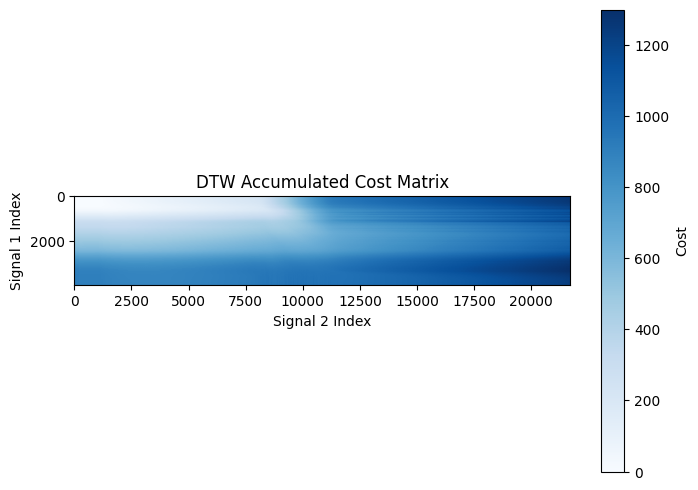

In [9]:
# ---------------------------------------------------------
# 6. Display DTW cost matrix
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
plt.imshow(dtw_matrix[1:, 1:], cmap='Blues', interpolation='nearest')
plt.title("DTW Accumulated Cost Matrix")
plt.xlabel("Signal 2 Index")
plt.ylabel("Signal 1 Index")
plt.colorbar(label="Cost")
plt.show()

In [10]:
# ---------------------------------------------------------
# 7. Extract DTW alignment path
# ---------------------------------------------------------
def extract_path(D):
    i, j = np.array(D.shape) - 1
    path = []

    while i > 0 and j > 0:
        path.append((i-1, j-1))

        directions = [
            (i-1, j-1),   # diagonal
            (i-1, j),     # up
            (i, j-1)      # left
        ]

        costs = [D[d] for d in directions]
        move = np.argmin(costs)

        i, j = directions[move]

    path.reverse()
    return path

path = extract_path(dtw_matrix)
px, py = zip(*path)

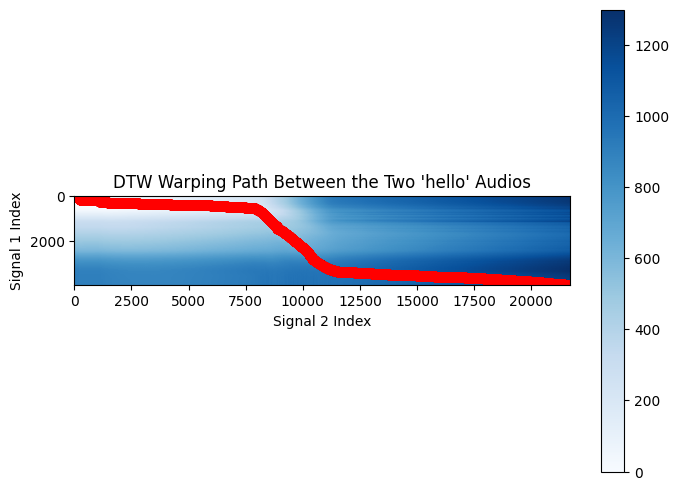

In [11]:
# ---------------------------------------------------------
# 8. Plot warping path
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
plt.imshow(dtw_matrix[1:,1:], cmap='Blues', interpolation='nearest')
plt.plot(py, px, '-o', color='red')
plt.title("DTW Warping Path Between the Two 'hello' Audios")
plt.xlabel("Signal 2 Index")
plt.ylabel("Signal 1 Index")
plt.colorbar()
plt.show()

In [12]:
# ---------------------------------------------------------
# 9. Final DTW distance
# ---------------------------------------------------------
dtw_distance = dtw_matrix[-1, -1]
print("Final DTW Distance:", dtw_distance)

Final DTW Distance: 1230.425062872103
